## Aprendizaje Profundo - Transfer Learning vs Fine-Tuning
### Emilio Alejandro Pérez Cerrillo | 07 de mayo de 2024

In [1]:
# keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
from keras import optimizers

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# otros
import matplotlib.pyplot as plt
from OneHotEncoder import OneHot
from tqdm.notebook import tqdm
import statistics as stds
from tabulate import tabulate

#### Función generadora de datos
Obtenemos datos para trabajar en con ellos a partir de la función `make_moons` de sklearn.

In [5]:
def make_moons2(ruido, muestras):
    return make_moons(n_samples=muestras, noise=ruido, random_state=17)

#### Generación del conjunto A, tarea secundaria
Generamos los datos a utilizar a partir de una semilla fija.

Dado que este **conjunto A** servirá para entrenar al modelo que después servirá para transferir su conocimiento, obtenemos una muestra de datos de tamaño considerable.

Para el preprocesamiento de los datos:
- los normalizamos mediante la función `MinMaxScaler` de sklearn,
- dividimos el conjunto en subconjuntos de entrenamiento y prueba mediante la función `train_test_split`, también de sklearn,
- aplicamos One Hot Encoding para crear vectores de las etiquetas, esta clase `OneHotEncoder` es de desarrollo propio.

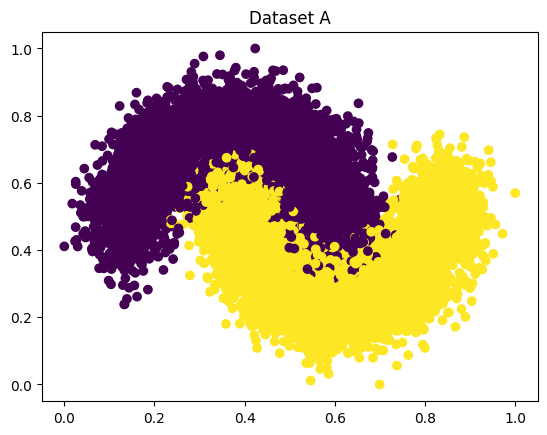

In [6]:
X_a, Y_a = make_moons2(0.2, 10000)

Scaler_a = MinMaxScaler()
X_a = Scaler_a.fit_transform(X_a)

plt.scatter(X_a[:,0],X_a[:,1], c=Y_a)
plt.title("Dataset A")
plt.show()

OH_a = OneHot()
Y_a = OH_a.encoder(Y_a)

X_a_tr, X_a_ts, Y_a_tr, Y_a_ts = train_test_split(X_a, Y_a, stratify=Y_a, test_size=0.2) 

#### Generación del conjunto B, tarea primaria
En esta ocasión, el **conjunto B** servirá para aplicar **fine-tuning**, por lo que la muestra es de tamaño menor al conjunto anterior. Así mismo, el porcentaje de ruido ha aumentado, pero, por la naturaleza de la generación de los datos, el dominio de ambos conjuntos de datos se mantiene similar. 

De igual manera, se preparan los datos y dividen en conjuntos de entrenamiento y prueba.

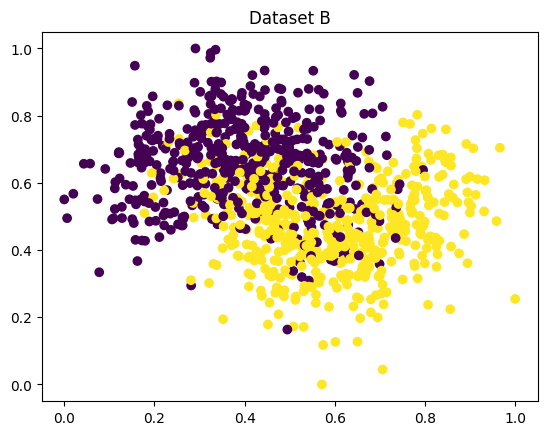

In [7]:
X_b, Y_b = make_moons2(0.45, 1000)

Scaler_b = MinMaxScaler()
X_b = Scaler_b.fit_transform(X_b)

plt.scatter(X_b[:,0],X_b[:,1], c=Y_b)
plt.title("Dataset B")
plt.show()

OH_b = OneHot()
Y_b = OH_b.encoder(Y_b)

X_b_tr, X_b_ts, Y_b_tr, Y_b_ts = train_test_split(X_b, Y_b, stratify=Y_b, test_size=0.2) 

### Declaración del modelo M1
Este modelo será entrenado con el **conjunto A** y posteriormente servirá para transferir su aprendizaje a otros modelos.

**M1** consiste de una capa de entrada de 2 neuronas, dos capas ocultas de 5 neuronas cada una con función de activación **ReLU** y una capa de salida de 2 neuronas con función de activación **softmax**. Utiliza como optimizador **ADAM** con tasa de aprendizaje de 0.001. 

El modelo entrenará por 100 épocas, utilizando el 10% del conjunto de entrenamiento para validación. Finalmente, evalúa el desempeño del modelo utilizando el conjunto de pruebas.

In [8]:
m1 = Sequential(name = "M1")

m1_interno = Sequential([
        Input(shape=(2,)),
        Dense(5, activation='relu'),
        Dense(5, activation='relu')
    ])
m1.add(m1_interno)
m1.add(Dense(2, activation='softmax'))

m1.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

H_m1 = m1.fit(X_a_tr, Y_a_tr, epochs=100, validation_split=0.1, verbose=0)
m1.evaluate(X_a_ts, Y_a_ts)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8696 - loss: 0.2873  


[0.27479591965675354, 0.8769999742507935]

### Declaración del modelo M2
Este modelo será entrenado con el **conjunto B** y posteriormente servirá para evaluar su desempeño contra el uso de las heurísticas **transfer learning** y **fine-tuning**.

**M2** consiste de una capa de entrada de 2 neuronas, dos capas ocultas de 5 neuronas cada una con función de activación **ReLU** y una capa de salida de 2 neuronas con función de activación **softmax**. Utiliza como optimizador ADAM con tasa de aprendizaje de 0.001. 

El modelo entrenará por 100 épocas, utilizando el 10% del conjunto de entrenamiento para validación. Finalmente, evalúa el desempeño del modelo utilizando el conjunto de pruebas.

In [9]:
m2 = Sequential(name = "M2")
m2.add(Input(shape=(2,)))
m2.add(Dense(5, activation='relu'))
m2.add(Dense(5, activation='relu'))
m2.add(Dense(2, activation='softmax'))

m2.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

H_m2 = m2.fit(X_b_tr, Y_b_tr, epochs=100, validation_split=0.1, verbose=0)
m2.evaluate(X_b_ts, Y_b_ts)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8360 - loss: 0.4103 


[0.40281298756599426, 0.824999988079071]

### Declaración del modelo M3: Transfer Learning
Este modelo es creado a partir del modelo **M1**, congelando el aprendizaje en todas las capas, adicionalmente añadimos una capa de salida con 2 neuronas y función de activación **softmax**. Utiliza como optimizador ADAM con tasa de aprendizaje de 0.01, esta tasa es más elevada, ya que necesitamos un mayor ajuste con menos datos. 

El modelo entrenará por 100 épocas, utilizando el 10% del conjunto de entrenamiento para validación. Finalmente, evalúa el desempeño del modelo utilizando el conjunto de pruebas.

In [10]:
m3_interno = m1_interno
m3_interno.trainable = False

m3 = Sequential(name = "M3")
m3.add(m3_interno)
m3.add(Dense(2, activation='softmax'))

m3.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

H_m3 = m3.fit(X_b_tr, Y_b_tr, epochs=100, validation_split=0.1, verbose=0)
m3.evaluate(X_b_ts, Y_b_ts)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.8139 - loss: 0.4347


[0.4165005385875702, 0.824999988079071]

### Declaración del modelo M4: Transfer Learning
Este modelo también es creado a partir del modelo **M1**, posee las mismas características que los anteriores, pero en esta ocasión se les proporcionan los pesos de **M1** desde el inicio de su entrenamiento. Igualmente, utiliza como optimizador **ADAM** con tasa de aprendizaje de 0.01, esta tasa es más elevada, ya que necesitamos un mayor ajuste con menos datos. 

El modelo entrenará por 100 épocas, utilizando el 10% del conjunto de entrenamiento para validación. Finalmente, evalúa el desempeño del modelo utilizando el conjunto de pruebas.

In [11]:
m4_interno = Sequential([
        Input(shape=(2,)),
        Dense(5, activation='relu'),
        Dense(5, activation='relu')
    ])
m4 = Sequential(name = "M4")
m4.add(m4_interno)
m4.add(Dense(2, activation='softmax'))

m4_interno.set_weights(m1_interno.weights)

m4.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

H_m4 = m4.fit(X_b_tr, Y_b_tr, epochs=100, validation_split=0.1, verbose=0)
m4.evaluate(X_b_ts, Y_b_ts)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8435 - loss: 0.4151 


[0.4028867781162262, 0.8399999737739563]

#### Experimentación

A continuación, repetiremos los pasos anteriores 35 veces para comparar el desempeño de los modelos en varias iteraciones.

In [12]:
m1_res = []
m2_res = []
m3_res = []
m4_res = []

for i in tqdm(range(35)):
    # MODELO 1 --------------------------------------------------------
    m1_interno = Sequential([
            Input(shape=(2,)),
            Dense(5, activation='relu'),
            Dense(5, activation='relu')
        ])
    m1 = Sequential(name = "M1")
    m1.add(m1_interno)
    m1.add(Dense(2, activation='softmax'))
    
    m1.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    m1.fit(X_a_tr, Y_a_tr, epochs=100, validation_split=0.1, verbose=0)
    # m1.evaluate(X_a_ts, Y_a_ts)

    # MODELO 2 --------------------------------------------------------
    m2 = Sequential(name = "M2")
    m2.add(Input(shape=(2,)))
    m2.add(Dense(5, activation='relu'))
    m2.add(Dense(5, activation='relu'))
    m2.add(Dense(2, activation='softmax'))
    
    m2.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    H_m2 = m2.fit(X_b_tr, Y_b_tr, epochs=100, validation_split=0.1, verbose=0)
    m2_res.append(m2.evaluate(X_b_ts, Y_b_ts, verbose=0, return_dict=True)['accuracy'])
    
    # MODELO 3 --------------------------------------------------------
    
    m3_interno = m1_interno
    m3_interno.trainable = False
    
    m3 = Sequential(name = "M3")
    m3.add(m3_interno)
    m3.add(Dense(2, activation='softmax'))
    
    m3.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])
    
    H_m3 = m3.fit(X_b_tr, Y_b_tr, epochs=100, validation_split=0.1, verbose=0)
    m3_res.append(m3.evaluate(X_b_ts, Y_b_ts, verbose=0, return_dict=True)['accuracy'])
    
    # MODELO 4 --------------------------------------------------------
    
    m4_interno = Sequential([
        Input(shape=(2,)),
        Dense(5, activation='relu'),
        Dense(5, activation='relu')
    ])
    m4 = Sequential(name = "M4")
    m4.add(m4_interno)
    m4.add(Dense(2, activation='softmax'))
    
    m4_interno.set_weights(m1_interno.weights)
    
    m4.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])
    
    H_m4 = m4.fit(X_b_tr, Y_b_tr, epochs=100, validation_split=0.1, verbose=0)
    m4_res.append(m4.evaluate(X_b_ts, Y_b_ts, verbose=0, return_dict=True)['accuracy'])
    
    # RESETEAR MODELOS/LIBERAR MEMORIA
    keras.backend.clear_session()


  0%|          | 0/35 [00:00<?, ?it/s]

#### Resultados

Finalmente, presentamos los datos estadísticos más relevantes en formato de tabla y mediante un gráfico de cajas y bigotes. Su análisis se realizará a continuación.

      Mínimo  µ ± σ            Mediana    Máximo
--  --------  -------------  ---------  --------
M2     0.5    0.8183±0.0555      0.825     0.84
M3     0.815  0.8331±0.0555      0.835     0.845
M4     0.82   0.8376±0.0555      0.84      0.86


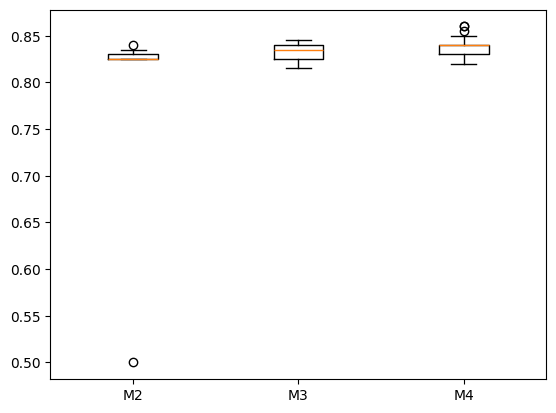

In [13]:
data = [["M2", min(m2_res), "{:.4f}±{:.4f}".format(stds.mean(m2_res),stds.stdev(m2_res)), stds.median(m2_res), max(m2_res)],
        ["M3", min(m3_res), "{:.4f}±{:.4f}".format(stds.mean(m3_res), stds.stdev(m2_res)), stds.median(m3_res), max(m3_res)],
        ["M4", min(m4_res), "{:.4f}±{:.4f}".format(stds.mean(m4_res), stds.stdev(m2_res)), stds.median(m4_res), max(m4_res)]]
print (tabulate(data, headers=["","Mínimo", "µ ± σ", "Mediana", "Máximo"]))

data = {'M2': m2_res, 'M3': m3_res,'M4': m4_res}
fig, ax = plt.subplots()
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
plt.show()

#### Conclusiones

En la tabla comparativa, así como el gráfico de cajas y bigotes presentados anteriormente se puede apreciar que los modelos **M3** y **M4** alcanzan un mejor desempeño que **M2**. A pesar de ser modelos casi idénticos en su arquitectura, con el único cambio siendo la tasa de aprendiza del optimizador, son consistentemente mejores. El valor medio de ambos modelos es mayor que el de **M2**, aunque los tres presentan una desviación estándar muy similar.
 
Ambos **M3** y **M4** presentan muy pocos datos atípicos, a diferencia de **M2** que suele tener una iteración en la que obtiene un rendimiento terrible de 0.5, comparable a no entrenar el modelo en lo absoluto y esperar que adivine. 

Este ejercicio fue sumamente práctico e ilustrativo, se agradece la oportunidad de revisar de primera mano el proceso de Transfer Learning y Fine-Tuning. Se pudo comprobar de primera mano que estas heurísticas efectivamente tienen un impacto positivo en el desempeño de un modelo que cumpla una tarea real, en este caso clasificación, y que estas heurísticas, aplicadas a un contexto industrial podría acelerar el proceso de desarrollo cuando se tienen muy pocos datos disponibles.

